In [1]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from ampligraph.utils import save_model, restore_model
from ampligraph.discovery import discover_facts
from sklearn.cluster import KMeans
from adjustText import adjust_text
from ampligraph.datasets import load_fb15k_237, load_wn18rr, load_yago3_10
import seaborn as sns
import pandas as pd
import ampligraph
import numpy as np
import matplotlib as mpl
import networkx as nx
import pickle


from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
    sse = []
    centroids_list = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        centroids_list.append(centroids)
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)
    return sse, centroids_list


Load datasets

In [3]:
fb = load_fb15k_237()  # load_fb15_237(add_reciprocal_rels=True) for conv n-1
fb_train = fb["train"]
fb_valid = fb["valid"]
fb_test = fb["test"]
fb_all = np.concatenate([fb_train, fb_valid, fb_test], 0)
fb_removed = np.concatenate([fb_valid[1::2], fb_test], 0)

wn = load_wn18rr()  # load_wn18rr(add_reciprocal_rels=True) for conv n-1
wn_train = wn["train"]
wn_valid = wn["valid"]
wn_test = wn["test"]
wn_all = np.concatenate([wn_train, wn_valid, wn_test], 0)
wn_removed = np.concatenate([wn["valid"][1::2], wn_test], 0)

yago = load_yago3_10()  # load_wn18rr(add_reciprocal_rels=True) for conv n-1
yago_train = yago["train"]
yago_valid = yago["valid"]
yago_test = yago["test"]
yago_all = np.concatenate([yago_train, yago_valid, yago_test], 0)
yago_removed = np.concatenate([yago["valid"][1::2], yago_test], 0)

codex_train = pd.read_csv("./codex-l/train.txt", delim_whitespace=True, names=['s', 'p', 'o']).to_numpy()
codex_valid = pd.read_csv("./codex-l/valid.txt", delim_whitespace=True, names=['s', 'p', 'o']).to_numpy()
codex_test = pd.read_csv("./codex-l/test.txt", delim_whitespace=True, names=['s', 'p', 'o']).to_numpy()
codex_all = np.concatenate([codex_train, codex_valid, codex_test], 0)
codex_removed = np.concatenate([codex_valid[1::2], codex_test], 0)

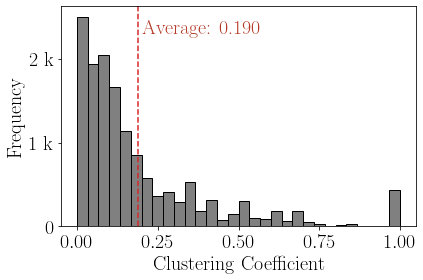

In [20]:
X = fb_train

G_fb = nx.Graph()
for row in X:
    G_fb.add_nodes_from([row[0], row[2]])
    G_fb.add_edge(row[0], row[2], name=row[1])
    
fb_local_cc = nx.algorithms.cluster.clustering(G_fb)
fb_global_cc = np.array(list(fb_local_cc.values())).mean() # global clustering coefficient

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(list(fb_local_cc.values()), bins=30, color='gray', edgecolor='black')
ax.set_xlabel('Clustering Coefficient', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.tick_params(labelsize=20)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.axvline(fb_global_cc, color='tab:red', linestyle='dashed')
ax.text(fb_global_cc + 0.01, ax.get_ylim()[1]*0.9, f'Average: {fb_global_cc:.3f}', color=(0.709, 0.232, 0.16), fontsize=20, verticalalignment='center')

# plt.title('Distribution of Clustering Coefficients', fontsize=20)
plt.tight_layout()
plt.show()

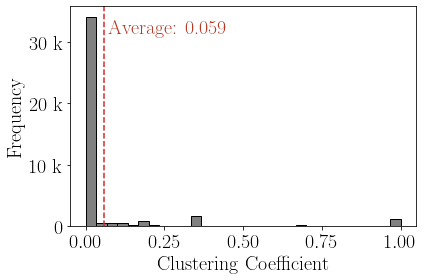

In [21]:
X2 = wn_train

G_wn = nx.Graph()
for row in X2:
    G_wn.add_nodes_from([row[0], row[2]])
    G_wn.add_edge(row[0], row[2], name=row[1])

wn_local_cc = nx.algorithms.cluster.clustering(G_wn)
wn_global_cc = np.array(list(wn_local_cc.values())).mean()  # global clustering coefficient

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(list(wn_local_cc.values()), bins=30, color='gray', edgecolor='black')
ax.set_xlabel('Clustering Coefficient', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.tick_params(labelsize=20)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.axvline(wn_global_cc, color='tab:red', linestyle='dashed')
ax.text(wn_global_cc + 0.01, ax.get_ylim()[1]*0.9, f'Average: {wn_global_cc:.3f}', color=(0.709, 0.232, 0.16), fontsize=20, verticalalignment='center')

# plt.title('Distribution of Clustering Coefficients', fontsize=20)
plt.tight_layout()
plt.show()

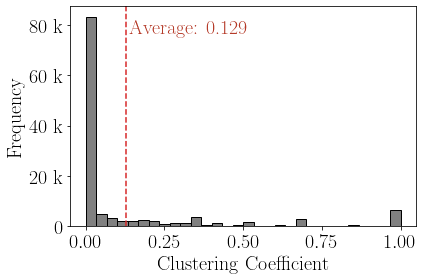

In [23]:
X3 = yago_train

G_yago = nx.Graph()
for row in X3:
    G_yago.add_nodes_from([row[0], row[2]])
    G_yago.add_edge(row[0], row[2], name=row[1])
    
yg_local_cc = nx.algorithms.cluster.clustering(G_yago)
yg_global_cc = np.array(list(yg_local_cc.values())).mean() # global clustering coefficient

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(list(yg_local_cc.values()), bins=30, color='gray', edgecolor='black')
ax.set_xlabel('Clustering Coefficient', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.tick_params(labelsize=20)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.axvline(yg_global_cc, color='tab:red', linestyle='dashed')
ax.text(yg_global_cc + 0.01, ax.get_ylim()[1]*0.9, f'Average: {yg_global_cc:.3f}', color=(0.709, 0.232, 0.16), fontsize=20, verticalalignment='center')

# plt.title('Distribution of Clustering Coefficients', fontsize=20)
plt.tight_layout()
plt.show()

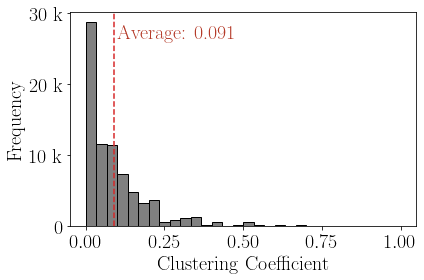

In [25]:
X4 = codex_train

G_codex = nx.Graph()
for row in X4:
    G_codex.add_nodes_from([row[0], row[2]])
    G_codex.add_edge(row[0], row[2], name=row[1])
    
cd_local_cc = nx.algorithms.cluster.clustering(G_codex)
cd_global_cc = np.array(list(cd_local_cc.values())).mean() # global clustering coefficient


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(list(cd_local_cc.values()), bins=30, color='gray', edgecolor='black')
ax.set_xlabel('Clustering Coefficient', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.tick_params(labelsize=20)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

ax.axvline(cd_global_cc, color='tab:red', linestyle='dashed')
ax.text(cd_global_cc + 0.01, ax.get_ylim()[1]*0.9, f'Average: {cd_global_cc:.3f}', color=(0.709, 0.232, 0.16), fontsize=20, verticalalignment='center')

# plt.title('Distribution of Clustering Coefficients', fontsize=20)
plt.tight_layout()
plt.show()

### Clustering coefficient and triangles value for fb15k-237

In [13]:
X = fb_train
 
G_fb = nx.Graph()
for row in X:
    G_fb.add_nodes_from([row[0], row[2]])
    G_fb.add_edge(row[0], row[2], name=row[1])
    
cc = nx.algorithms.cluster.clustering(G_fb)
triangles = nx.triangles(G_fb)

cc = list(cc.values())
triangles = list(triangles.values())

cc_weights = cc/np.sum(cc)
t_weights = triangles/np.sum(triangles)

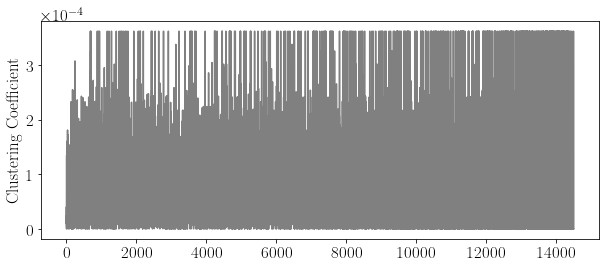

In [16]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(cc_weights, color='gray')  # Set plot color to gray

# Set label and font size
ax.set_ylabel('Clustering Coefficient', fontsize=17)

# Set tick label format
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Set font size for tick labels
ax.tick_params(axis='both', labelsize=17)

# Set font size for the y-axis offset text (e.g., 1e-4)
ax.yaxis.offsetText.set_fontsize(17)

plt.show()


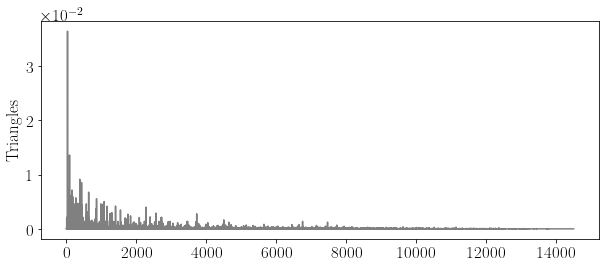

In [17]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t_weights, color='gray')  # Set plot color to gray

# Set label and font size
ax.set_ylabel('Triangles', fontsize=17)

# Set tick label format
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Set font size for tick labels
ax.tick_params(axis='both', labelsize=17)

# Set font size for the y-axis offset text (e.g., 1e-4)
ax.yaxis.offsetText.set_fontsize(17)

plt.show()
